# 🔵 Optimized Particle Collision Simulation in Jupyter Notebook  

## 📌 Overview
This Jupyter Notebook simulates a **real-time particle collision system** using **Matplotlib Animation**. The system is optimized with a **grid-based spatial partitioning** approach to improve performance, reducing the complexity from **O(n²) to O(n)** for collision detection.  

👨‍💻 Author
Tigist Wondimneh - GSR/5506/17

In [17]:
import pygame
import numpy as np
import random
import math
import heapq

In [33]:
WIDTH, HEIGHT = 10, 10
NUM_PARTICLES = 20
FPS = 60
CELL_SIZE = 20

In [19]:
collision_type = "elastic"


1. Particle Class

Each particle has position, velocity, and radius. It moves within the defined area and bounces off the walls.

In [20]:
class Particle:
    def __init__(self, x, y, vx, vy, radius, mass, color):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.radius = radius
        self.mass = mass
        self.color = color
        self.next_collision_time = float("inf")

    def move(self):
        self.x += self.vx
        self.y += self.vy

        if self.x - self.radius < 0 or self.x + self.radius > WIDTH:
            self.vx *= -1
        if self.y - self.radius < 0 or self.y + self.radius > HEIGHT:
            self.vy *= -1


    def draw(self, screen):
        pygame.draw.circle(screen, self.color, (int(self.x), int(self.y)), self.radius)


2. Optimized Collision Detection


Instead of checking all pairs (O(n²)), we divide the space into a grid. Each particle is assigned to a cell, and collisions are only checked within neighboring cells.

In [21]:
class Grid:
    def __init__(self, width, height, cell_size):
        self.cell_size = cell_size
        self.cols = width // cell_size
        self.rows = height // cell_size
        self.grid = {}

    def clear(self):
        self.grid = {}

    def add_particle(self, particle):
        col = int(particle.x // self.cell_size)
        row = int(particle.y // self.cell_size)
        if (col, row) not in self.grid:
            self.grid[(col, row)] = []
        self.grid[(col, row)].append(particle)

    def get_nearby_particles(self, particle):
        col = int(particle.x // self.cell_size)
        row = int(particle.y // self.cell_size)
        nearby_particles = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor = (col + dx, row + dy)
                if neighbor in self.grid:
                    nearby_particles.extend(self.grid[neighbor])
        return nearby_particles


In [59]:
class Event:
    def __init__(self, time, particle_a, particle_b):
        self.time = time
        self.particle_a = particle_a
        self.particle_b = particle_b

    def __lt__(self, other):
        return self.time < other.time

class EventQueue:
    def __init__(self):
        self.events = []

    def add_event(self, event):
        heapq.heappush(self.events, event)

    def get_next_event(self):
        return heapq.heappop(self.events) if self.events else None

    def clear(self):
        self.events = []


3. Collision Handling

A collision is detected when the distance between two particles is smaller than their combined radii. When a collision occurs, momentum is exchanged to simulate a realistic elastic collision.

In [24]:
def check_collision(p1, p2):
    distance = math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)
    return distance <= p1.radius + p2.radius


In [25]:
def resolve_collision(p1, p2, collision_type):
    dx, dy = p2.x - p1.x, p2.y - p1.y
    distance = math.sqrt(dx**2 + dy**2)

    if distance == 0:
        return

    nx, ny = dx / distance, dy / distance
    tx, ty = -ny, nx

    v1n = nx * p1.vx + ny * p1.vy
    v1t = tx * p1.vx + ty * p1.vy
    v2n = nx * p2.vx + ny * p2.vy
    v2t = tx * p2.vx + ty * p2.vy

    if collision_type == "elastic":
        v1n_new = (v1n * (p1.mass - p2.mass) + 2 * p2.mass * v2n) / (p1.mass + p2.mass)
        v2n_new = (v2n * (p2.mass - p1.mass) + 2 * p1.mass * v1n) / (p1.mass + p2.mass)
    else:  # Inelastic
        v1n_new = v2n_new = (v1n * p1.mass + v2n * p2.mass) / (p1.mass + p2.mass)
    p1.vx = v1n_new * nx + v1t * tx
    p1.vy = v1n_new * ny + v1t * ty
    p2.vx = v2n_new * nx + v2t * tx
    p2.vy = v2n_new * ny + v2t * ty


In [26]:
particles = []
for _ in range(NUM_PARTICLES):
    particles.append(Particle(
        random.randint(50, WIDTH - 50),
        random.randint(50, HEIGHT - 50),
        random.uniform(-2, 2),
        random.uniform(-2, 2),
        random.randint(10, 20),
        random.uniform(1, 5),
        (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
    ))

In [ ]:

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Particle Collision Simulation")
font = pygame.font.SysFont(None, 36)
clock = pygame.time.Clock()

menu_rect = pygame.Rect(10, 10, 200, 60)
option_rects = {
    "elastic": pygame.Rect(10, 10, 200, 30)
}
menu_open = False

running = True
while running:
    screen.fill((0, 0, 0))

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if menu_rect.collidepoint(event.pos):
                menu_open = not menu_open
            elif menu_open:
                for option, rect in option_rects.items():
                    if rect.collidepoint(event.pos):
                        collision_type = option
                        menu_open = False

    pygame.draw.rect(screen, (255, 255, 255), menu_rect)
    menu_text = font.render(f"Collision: {collision_type}", True, (0, 0, 0))
    screen.blit(menu_text, (menu_rect.x + 5, menu_rect.y + 5))

    if menu_open:
        for option, rect in option_rects.items():
            pygame.draw.rect(screen, (200, 200, 200), rect)
            option_text = font.render(option.capitalize(), True, (0, 0, 0))
            screen.blit(option_text, (rect.x + 5, rect.y + 5))

    for particle in particles:
        particle.move()
        particle.draw(screen)

    # Check for collisions
    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            if check_collision(particles[i], particles[j]):
                resolve_collision(particles[i], particles[j], collision_type)

    pygame.display.flip()
    clock.tick(FPS)

pygame.quit()


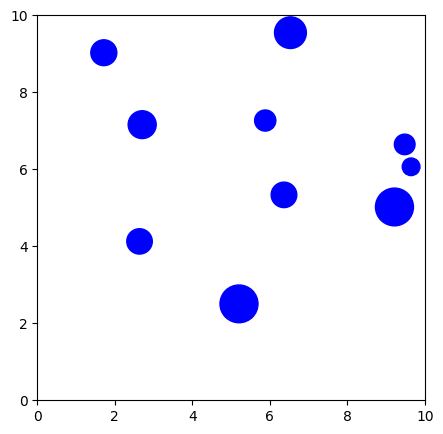

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math

def update(frame):
    plt.clf()
    plt.xlim(0, WIDTH)
    plt.ylim(0, HEIGHT)

    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            if check_collision(particles[i], particles[j]):
                resolve_collision(particles[i], particles[j])

    for particle in particles:
        particle.move()
        plt.gca().add_patch(plt.Circle((particle.x, particle.y), particle.radius, color='blue'))

fig = plt.figure(figsize=(5, 5))
ani = animation.FuncAnimation(fig, update, frames=200, interval=50)

from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Optimized Particle Collision Simulation")
font = pygame.font.SysFont(None, 36)
clock = pygame.time.Clock()

grid = Grid(WIDTH, HEIGHT, CELL_SIZE)
event_queue = EventQueue()

menu_rect = pygame.Rect(10, 10, 200, 60)
option_rects = {"elastic": pygame.Rect(10, 10, 200, 30)}
menu_open = False

running = True
while running:
    screen.fill((0, 0, 0))

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if menu_rect.collidepoint(event.pos):
                menu_open = not menu_open
            elif menu_open:
                for option, rect in option_rects.items():
                    if rect.collidepoint(event.pos):
                        collision_type = option
                        menu_open = False

    pygame.draw.rect(screen, (255, 255, 255), menu_rect)
    menu_text = font.render(f"Collision: {collision_type}", True, (0, 0, 0))
    screen.blit(menu_text, (menu_rect.x + 5, menu_rect.y + 5))

    if menu_open:
        for option, rect in option_rects.items():
            pygame.draw.rect(screen, (200, 200, 200), rect)
            option_text = font.render(option.capitalize(), True, (0, 0, 0))
            screen.blit(option_text, (rect.x + 5, rect.y + 5))

    grid.clear()
    for particle in particles:
        grid.add_particle(particle)

    for particle in particles:
        particle.move(1)
        particle.draw(screen)

    for particle in particles:
        for neighbor in grid.get_nearby_particles(particle):
            if neighbor != particle and check_collision(particle, neighbor):
                resolve_collision(particle, neighbor, collision_type)

    pygame.display.flip()
    clock.tick(FPS)

pygame.quit()


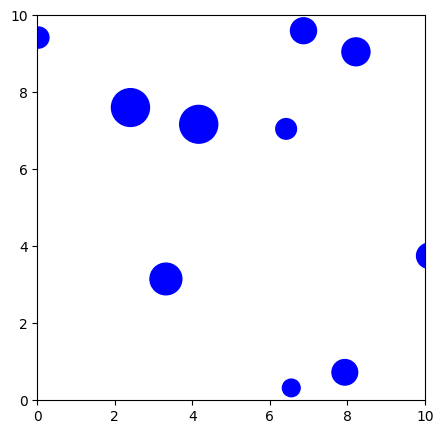

In [58]:
grid = Grid(WIDTH, HEIGHT, CELL_SIZE)

def update(frame):
    plt.clf()
    plt.xlim(0, WIDTH)
    plt.ylim(0, HEIGHT)
    grid.grid.clear()
    for particle in particles:
        grid.add_particle(particle)

    for particle in particles:
        particle.move()

        for neighbor in grid.get_nearby_particles(particle):
            if neighbor != particle and check_collision(particle, neighbor):
                resolve_collision(particle, neighbor)

        plt.gca().add_patch(plt.Circle((particle.x, particle.y), particle.radius, color='blue'))
fig = plt.figure(figsize=(5, 5))
ani = animation.FuncAnimation(fig, update, frames=100, interval=50, blit=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

👨‍💻 Author
Tigist Wondimneh

GSR/5506/17